In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import interpolate
import pandas as pd
import os
import faceted as faceted
from fair.forcing.ghg import meinshausen2020
import xarray as xr
import glob
import utils
import os

/home/tarshish/micromamba/envs/zec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.set_plot_configs(plt, fsize=8)

In [3]:
results_dir = os.path.realpath('results')
datasets_dir = os.path.realpath('datasets')

In [5]:
results_dir = os.path.realpath('../../results')
datasets_dir = os.path.realpath('../../datasets')

In [6]:
# Historical GMST data
df_gmst = pd.read_csv(datasets_dir+"/fair_calibrate/data/forcing/IGCC_GMST_1850-2022.csv")
gmst = df_gmst["gmst"].values

In [9]:
results_dir

'/home/tarshish/Documents/research/zec/results'

In [8]:
ds = xr.open_mfdataset(results_dir+"/fair/ssp*_netzero.nc")
ds_ZEC = xr.open_mfdataset(results_dir+"/fair/historical_netzero.nc")
ds_ZEC['scenario'] = ['historical']
ds = xr.concat([ds, ds_ZEC], dim='scenario')
ds = ds.sel(scenario=["historical","ssp119", "ssp126", "ssp434","ssp534-over"])

OSError: no files to open

In [ ]:
#process SSP FaIR runs
co2_emissions_21_century = (ds.emissions.sel(specie="CO2 FFI") + ds.emissions.sel(specie="CO2 AFOLU")).sel(timepoint=slice(2000,2100)).median("config")
net_zero_times = co2_emissions_21_century.timepoint[abs(co2_emissions_21_century).argmin(dim="timepoint")] - .5
#temperature peaks
T_net_zero = ds.temperature.isel(layer=0).sel(timebound=net_zero_times).quantile(.5, dim='config').compute()
#temperature at year 3000
Tfinal = ds.temperature.isel(layer=0, timebound=-1).quantile(.5, dim='config').compute()
#carbon emissions at year 3000
median = ds.temperature.isel(layer=0).quantile(.5, dim='config').compute()
quantile_16 = ds.temperature.isel(layer=0).quantile(.16, dim='config').compute()
quantile_84 = ds.temperature.isel(layer=0).quantile(.84, dim='config').compute()

In [6]:
Tze = ds.temperature.sel(timebound=net_zero_times).isel(layer=0)
Tf = ds.temperature.sel(timebound=3000).isel(layer=0)
ZEC_div_Tze = (Tf - Tze)/Tze

In [7]:
sample_range = np.linspace(-1, 1, 1000)

kde_results = {}

# Iterate over each scenario
for scenario in ZEC_div_Tze['scenario']:
    # Extract the values for the current scenario
    data_for_scenario = ZEC_div_Tze.sel(scenario=scenario).values
    
    # Compute KDE for the current scenario
    kde = stats.gaussian_kde(data_for_scenario, bw_method="silverman")
    
    # Evaluate the KDE on the sample range
    kde_data = kde.evaluate(sample_range)
    
    # Store the result in the dictionary (or another xarray if preferred)
    kde_results[scenario.values.item()] = kde_data

kde_xarray = xr.DataArray(
    np.array(list(kde_results.values())), 
    coords=[list(kde_results.keys()), sample_range], 
    dims=["scenario", "sample_range"]
)

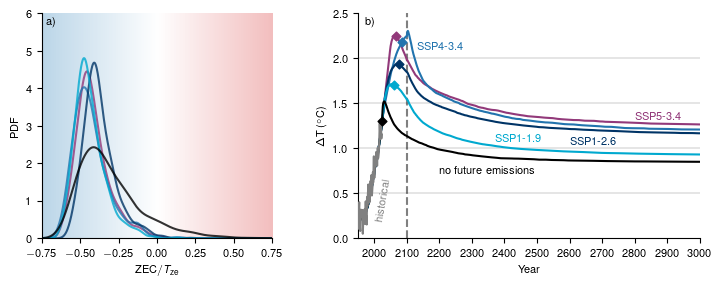

In [8]:
# Define your figure and axis sizes
figheight = 3
figwidth = 7
hspace = .1
wspace = .2

markersize = 20
markershape = "D"
linewidth=1.5

# Set up the figure and subplots with swapped widths
fig = plt.figure(figsize=(figwidth, figheight))
gs = fig.add_gridspec(1, 2, width_ratios=(1.35, 2), wspace=.3)
ax0 = fig.add_subplot(gs[0])  
ax1 = fig.add_subplot(gs[1])  

fig.subplots_adjust(left=.05, right=.99, top=.9, bottom=.15) 

# Right-hand plot (now ax0): KDE plot
for scenario in kde_xarray.scenario[::-1]:
    ax0.plot(sample_range, kde_xarray.sel(scenario=scenario), color=utils.get_color(scenario.item()),
             linewidth=linewidth, alpha=.8)
ax0.set_xlim([-.75, .75])
ax0.set_ylim([0, 6])
ax0.set_xlabel(r"$\text{ZEC}/T_\text{ze}$")
ax0.set_ylabel(r"PDF")
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

# color gradient 
gradient = np.linspace(-0.75, 0.25, 100)  # X-axis gradient
gradient = np.tile(gradient, (100, 1))  # Create a 2D gradient for background
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#1f77b4", "white", "#d62728"])
ax0.imshow(gradient, aspect='auto', extent=[-0.75, 0.75, 0, 6], origin='lower', cmap=cmap, alpha=0.3)


# Left-hand plot (now ax1): time and temperature anomaly
for scenario in ds.sel(scenario=['ssp534-over', 'ssp434', 'ssp126', 'ssp119', 'historical']).scenario:
    d = ds.sel(scenario=scenario)
    ax1.plot(d.timebound, median.sel(scenario=scenario), color=utils.get_color(scenario.item()), zorder=3,
             linewidth=linewidth, label=utils.get_title(scenario.item()))
    
    # Scatter points for net-zero times and final temperatures
    ax1.scatter(ds.timebound.sel(timebound=net_zero_times.sel(scenario=scenario)), T_net_zero.sel(scenario=scenario),
                zorder=5, color=utils.get_color(scenario.item()), marker=markershape, s=markersize)

    
    # print(f"Total cooling after peak for {scenario.item()} is "
    #       f"{-np.round((T_net_zero - Tfinal).sel(scenario=scenario).values, 2)} K")

ax1.plot(df_gmst["time"], gmst, color="grey", zorder=3, label='historical')

ax1.set_ylim([0, 2.5])
ax1.set_xlim([1950, 3000])
ax1.set_ylabel(r"$\Delta$T (${}^\circ$C)")
ax1.set_xlabel(r"Year")
ax1.set_xticks(np.arange(2000, 3100, 100))  # Simplified x-ticks for clarity
ax1.axvline(2100, ymax=2.5, linestyle='dashed', color='grey')

ax1.text(2000, .2, "historical", rotation=80, color="grey")
ax1.text(2200, .72, "no future emissions", color=utils.get_color("historical"))
ax1.text(2800, 1.32, "SSP5-3.4", color=utils.get_color("ssp534-over"))
ax1.text(2600, 1.05, "SSP1-2.6", color=utils.get_color("ssp126"))
ax1.text(2370, 1.08, "SSP1-1.9", color=utils.get_color("ssp119"))
ax1.text(2130, 2.1, "SSP4-3.4", color=utils.get_color("ssp434"))

for ydata in [.5,1,1.5,2]:
    ax1.axhline(ydata, linestyle='solid', alpha=0.6, color="black", linewidth=.25)
    
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

for ax, label in zip([ax0,ax1], ["a)", "b)"]):
    ax.text(0.02,0.96,label,transform=ax.transAxes,horizontalalignment="left",verticalalignment="center")

# # Save and show the figure
fig.savefig(results_dir+"/figures/fig_3.pdf")
plt.show()

In [ ]:
# f = utils.gen_fair_ensemble(["ssp119","ssp126","ssp534-over"], final_year=2100, ZEC_year=2100)

In [ ]:
# f.run()

In [ ]:
# lamb = f.climate_configs.ocean_heat_transfer.isel(layer=0)
# Fze = f.forcing_sum #.sel(specie="CO2") #.rolling(timebounds=5, center=False).mean()
# Teq = Fze/lamb 
# Tnow = f.temperature.isel(layer=0)

In [ ]:
# co2_emissions_21_century = (f.emissions.sel(specie="CO2 FFI") + f.emissions.sel(specie="CO2 AFOLU")).sel(timepoints=slice(2000,2100)).median("config")
# net_zero_times = co2_emissions_21_century.timepoints[abs(co2_emissions_21_century).argmin(dim="timepoints")] - .5

In [ ]:
# def compute_final_forcing(f):

#     GtCO2_to_ppm = f.species_configs.concentration_per_emission.sel(specie="CO2")
#     preindustrial_concentrations =  f.concentration.isel(timebounds=0)
#     Af = f.species_configs.partition_fraction.sel(specie="CO2", gasbox=0)
#     final_concentrations = preindustrial_concentrations + GtCO2_to_ppm*Af*f.cumulative_emissions.sel(specie="CO2")
#     final_concentrations = final_concentrations.transpose("timebounds", "scenario", "config", "specie")
#     Ff_CO2 = xr.ones_like(final_concentrations.sel(specie="CO2"))*np.nan
#     for i_timepoint in np.arange(f._n_timepoints):
#         Ff_CO2[i_timepoint,...] = meinshausen2020(                                                    
#                                 final_concentrations.values[i_timepoint+1:i_timepoint+2,...],        
#                                 f.species_configs.forcing_reference_concentration.values[None, None, ...]              
#                                 * np.ones(                                                          
#                                     (1, f._n_scenarios, f._n_configs, f._n_species)        
#                                 ),       
#                                 f.species_configs.forcing_scale.values[None, None, ...]*(1 + f.species_configs["tropospheric_adjustment"].data),
#                                 f.species_configs.greenhouse_gas_radiative_efficiency.values[None, None, ...],         
#                                 f._co2_indices,                                                  
#                                 f._ch4_indices,                                                  
#                                 f._n2o_indices,                                                  
#                                 f._minor_ghg_indices,                                            
#                     )[0,...,2]
#     Ff = Ff_CO2 + f.forcing.sel(specie="Land use")
#     return Ff

In [ ]:
# Ff = compute_final_forcing(f)

In [ ]:
# forcing_dis = Ff/Fze
# thermal_dis = Tnow/Teq

In [ ]:
# # Assuming faceted and all relevant libraries are already imported as in your script
# fig, axes = faceted.faceted(1, 2, width=7,
#                              aspect=1.0, bottom_pad=.5, left_pad=.6,
#                              top_pad=.3, right_pad=1.2, internal_pad=.6)
# colors = []
# for scenario in f.scenarios:
#     forcing_dis.sel(scenario=scenario).median("config").sel(timebounds=slice(2000,2100)).plot(ax=axes[0], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])
#     thermal_dis.sel(scenario=scenario).median("config").sel(timebounds=slice(2000,2100)).plot(ax=axes[1], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])

#     forcing_dis_net_zero = forcing_dis.median("config").sel(scenario=scenario, 
#                                                             timebounds=net_zero_times.sel(scenario=scenario).values)
#     thermal_dis_net_zero = thermal_dis.median("config").sel(scenario=scenario,
#                                                             timebounds=net_zero_times.sel(scenario=scenario).values)
#     axes[0].scatter(forcing_dis_net_zero.timebounds.values, 
#                     forcing_dis_net_zero.values, 
#                  zorder=5, color=ar6_colors[scenario]) 
                                                            
#     axes[1].scatter(thermal_dis_net_zero.timebounds.values, 
#                     thermal_dis_net_zero.values, 
#                  zorder=5, color=ar6_colors[scenario]) 
                 
#     colors.append(ar6_colors[scenario])

# axes[1].axhline(.6, color="grey", linestyle="dashed")
# axes[1].text(2085, .63, "TCR/ECS", ha="center", va="center", fontsize=10, color="grey")

# for ax in axes:
#     ax.set_ylim([.1,.9])
#     ax.set_title(" " )
#     ax.set_xlim([2000,2100])
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.set_xlabel(" ")

# axes[0].text(.03, .95, "a)", transform=axes[0].transAxes)
# axes[1].text(.03, .95, "b)", transform=axes[1].transAxes)
# axes[1].legend(fontsize=10, handlelength=.6, handletextpad=.4, frameon=False, loc="lower right", labelcolor=colors)
               
# axes[0].set_ylabel("F$_\mathrm{f}$/F$_\mathrm{ze}$")
# axes[1].set_ylabel("T/T$_\mathrm{eq}$")

# fig.savefig("/home/tarshish/Documents/research/ZEC/results/comparing_disequilibria.pdf", bbox_inches="tight")

In [ ]:
# # Assuming faceted and all relevant libraries are already imported as in your script
# fig, axes = faceted.faceted(1, 3, width=7, sharey=False,
#                              aspect=1.0, bottom_pad=.5, left_pad=.6,
#                              top_pad=.3, right_pad=1.2, internal_pad=.7)
# colors = []
# for scenario in f.scenarios:
#     f.forcing_sum.sel(scenario=scenario).median("config").sel(timebounds=slice(2000,2100)).plot(ax=axes[0], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])

#     forcing_net_zero = f.forcing_sum.sel(scenario=scenario).median("config").sel(timebounds=net_zero_times.sel(scenario=scenario).values)
    
#     axes[0].scatter(forcing_net_zero.timebounds.values, 
#                     forcing_net_zero.values, 
#                  zorder=5, color=ar6_colors[scenario]) 


#     Ff.sel(scenario=scenario).median("config").sel(timebounds=slice(2000,2100)).plot(ax=axes[1], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])
#     f.temperature.isel(layer=0).sel(scenario=scenario).median("config").sel(timebounds=slice(2000,2100)).plot(ax=axes[2], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])

#     #f.emissions.sel(specie="CO2").sel(scenario=scenario).median("config").sel(timepoints=slice(2000,2100)).plot(ax=axes[1], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])
#     colors.append(ar6_colors[scenario])

# axes[1].axhline(.6, color="grey", linestyle="dashed")
# axes[1].text(2085, .63, "TCR/ECS", ha="center", va="center", fontsize=10, color="grey")

# for ax in axes:
#     #ax.set_ylim([.1,.9])
#     ax.set_title(" " )
#     ax.set_xlim([2000,2100])
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.grid()
#     #ax.set_xlabel(" ")

# axes[0].text(.03, .95, "a)", transform=axes[0].transAxes)
# axes[1].text(.03, .95, "b)", transform=axes[1].transAxes)
# axes[1].legend(fontsize=10, handlelength=.6, handletextpad=.4, frameon=False, loc="lower right", labelcolor=colors)
               
# axes[0].set_ylabel("transient forcing")
# axes[1].set_ylabel("final forcing")

In [ ]:
# fig, (axis,) = faceted.faceted(1,1, aspect=1, width=4)

# for scenario in f.scenarios:

#     y = f.forcing_sum.sel(scenario=scenario).sel(timebounds=slice(None, net_zero_times.sel(scenario=scenario).values)).median("config")
#     x = f.cumulative_emissions.sel(specie="CO2", scenario=scenario).sel(timebounds=slice(None, net_zero_times.sel(scenario=scenario).values)).median("config")

#     axis.plot(x, y, color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])

# axis.set_ylim(0,None)
# axis.set_xlim(0,None)
# axis.set_xlabel("$C_{emit}$\,\,[GtC]")
# axis.set_ylabel("$F\,\,$ [W/m$^2$]")
# fig.savefig("/home/tarshish/Documents/research/ZEC/results/forcing_vs_Cemit.pdf", bbox_inches="tight")

In [ ]:
# def remove_CO2(f):
#     delta_f = f.forcing_sum - f.forcing.sel(specie="CO2") 
#     return delta_f

In [ ]:
# f.cumulative_emissions.isel(specie=2).sel(timebounds=slice(2024,2060)).median("config").plot.line(x="timebounds")

In [ ]:
# fig, (axis,) = faceted.faceted(1,1)

# y = f.temperature.isel(layer=0, scenario=0).sel(timebounds=slice(2024,2060))
# x = f.temperature.sel(timebounds=slice(2024,2060)).timebounds

# utils.plot_median(x,y,axis,spread=[25,75])

# axis.set_xlabel(" ")
# axis.set_title(" ")